Calculate the Bayes Factor for the stellar mass to determine whether the void and wall samples are drawn from the same or different parent distributions.

In [1]:
from astropy.table import Table
from astropy.io import fits

import numpy as np

import sys

import pickle

import dynesty
from dynesty import plotting as dyplot

import matplotlib
import matplotlib.pyplot as plt

from functions import Model_1_fit, Model_2_fit, Model_1_plot, Model_2_plot, Model_1_sampler, Model_2_sampler, uniform, jeffreys

#from scipy import stats
#from scipy.optimize import curve_fit
#from scipy.stats import skewnorm

np.set_printoptions(threshold=sys.maxsize)

In [2]:
#matplotlib.rcParams['text.usetex']=True
matplotlib.rc('font', size=14)
#matplotlib.rc('text', usetex=True)
matplotlib.rc('font', family='DejaVu Sans')

# Data

In [3]:
data_filename = '../../../../data/NSA_v1_0_1_VAGC_vflag-V2-VF.fits'

hdu = fits.open(data_filename)
data = Table(hdu[1].data)
hdu.close()

## Just keep the main SDSS DR7 footprint

In [4]:
# When the catalog is the NSA, only keep those objects which were originally in the DR7 LSS
catalog_SDSS = data[data['IN_DR7_LSS'] == 1]

ra_boolean = np.logical_and(catalog_SDSS['RA'] > 110, catalog_SDSS['RA'] < 270)
catalog_north = catalog_SDSS[ra_boolean]

strip_boolean = np.logical_and.reduce([catalog_north['RA'] > 250, 
                                       catalog_north['RA'] < 269, 
                                       catalog_north['DEC'] > 51, 
                                       catalog_north['DEC'] < 67])
catalog_main = catalog_north[~strip_boolean]

In [5]:
################################################################################
# stellar mass
#-------------------------------------------------------------------------------
Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS'])
################################################################################

'''
################################################################################
# color
#-------------------------------------------------------------------------------
u_r_NSA = np.array(catalog_main['u_r'])

g_r_NSA = np.array(catalog_main['g_r'])
################################################################################


################################################################################
# absolute magnitude
#-------------------------------------------------------------------------------
rabsmag_NSA = np.array(catalog_main['ELPETRO_ABSMAG'][:,4])
################################################################################


################################################################################
# star formation rate and specific SPR
#-------------------------------------------------------------------------------
SFR  = np.array(catalog_main['SFR'])

sSFR = np.array(catalog_main['sSFR'])
################################################################################
''';

/var/folders/5x/2533z9ns34n_8ghxd5f6hl0c0000gn/T/ipykernel_62700/3681242741.py:4: RuntimeWarning: divide by zero encountered in log10
  Mstar_NSA = np.log10(catalog_main['ELPETRO_MASS'])


## Separate galaxies by their LSS classifications

### $V^2$

In [6]:
wall_v2 = catalog_main['vflag_V2'] == 0
void_v2 = catalog_main['vflag_V2'] == 1
edge_v2 = catalog_main['vflag_V2'] == 2
out_v2 = catalog_main['vflag_V2'] == 9

### VoidFinder

In [7]:
wall_vf = catalog_main['vflag_VF'] == 0
void_vf = catalog_main['vflag_VF'] == 1
edge_vf = catalog_main['vflag_VF'] == 2
out_vf = catalog_main['vflag_VF'] == 9

# Fit the distributions with skewnormal distributions

Both one- and two-parent models

In [8]:
labels1_uni = ['s', 'a', r'$\mu$', r'$\sigma$', 'skew']
labels2_uni = ['a', r'$\mu_a$', r'$\sigma_a$', 'skew$_a$', 'b', r'$\mu_b$', r'$\sigma_b$', 'skew$_b$']

## $M_*$

This is a unimodal distribution

In [9]:
Mstar_bins = np.linspace(5.9, 12, 135)

### 1-parent model

In [19]:
Mstar_fit_bounds1 = [[0.1, 3],      # s ...... Gaussian 1 to 2 scale factor
                     [1000, 50000], # a ...... Gaussian amplitude
                     [10, 11],      # mu ..... Gaussian location
                     [0.5, 1],     # sigma .. Gaussian scale
                     [-5, 0]]      # skew ... Gaussian skew

V2_Mstar_bestfit1 = Model_1_fit(Mstar_fit_bounds1, 
                                Mstar_NSA[wall_v2], 
                                Mstar_NSA[void_v2], 
                                Mstar_bins, 
                                1, 
                                p0=[2.29, 4640, 10.54, 0.73, -2.93])

VF_Mstar_bestfit1 = Model_1_fit(Mstar_fit_bounds1, 
                                Mstar_NSA[wall_vf], 
                                Mstar_NSA[void_vf], 
                                Mstar_bins, 
                                1, 
                                p0=[0.36, 10645, 10.5, 0.74, -2.97])

running minimizer...this might take a few minutes...
running minimizer...this might take a few minutes...


In [20]:
V2_Mstar_bestfit1

      fun: 9675.097662193377
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.33705874, -1.21964529,  0.24556355, -0.06366463,  1.43554645])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 108
      nit: 16
     njev: 18
   status: 0
  success: True
        x: array([ 2.40710927e+00,  4.63951528e+03,  1.06086225e+01,  9.27204771e-01,
       -3.37857097e+00])

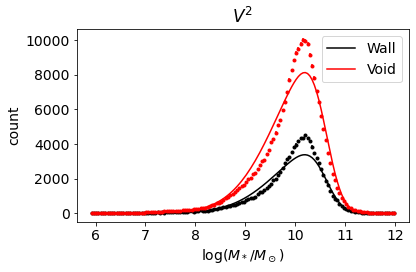

In [21]:
Model_1_plot(V2_Mstar_bestfit1.x, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             1, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$')

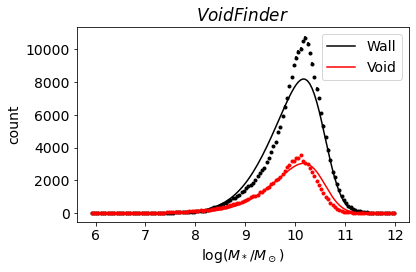

In [22]:
Model_1_plot(VF_Mstar_bestfit1.x, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             1, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$VoidFinder$')

In [23]:
VF_Mstar_bestfit1

      fun: 10424.548697407452
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.10531949, -0.9257912 , -0.01782609,  0.12987584,  0.20081643])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 96
      nit: 13
     njev: 16
   status: 0
  success: True
        x: array([ 3.70850364e-01,  1.06450034e+04,  1.05748636e+01,  8.53763774e-01,
       -2.98747070e+00])

#### Nested sampling of Likelihood and Priors

In [28]:
def prior_xform1_uni_V2(u):
    '''
    Priors for the 5 parameters of unimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(0.1, 3, u[0])
    a = jeffreys(1000, 5000, u[1])
    mu = uniform(10, 12, u[2])
    sigma = uniform(0.01, 2, u[3])
    skew = uniform(-5, 0, u[4])

    return s, a, mu, sigma, skew

In [29]:
Model_1_sampler(prior_xform1_uni_V2, 
                Mstar_NSA[wall_v2], 
                Mstar_NSA[void_v2], 
                Mstar_bins, 
                1, 
                '_Mstar_V2')

running the nested sampler... this might take from minutes to hours...


29240it [03:35, 135.76it/s, batch: 8 | bound: 91 | nc: 1 | ncall: 85158 | eff(%): 34.336 | loglstar: -9529.603 < -9522.550 < -9523.349 | logz: -9551.570 +/-  0.319 | stop:  0.970]           

sampler output saved as pickle file 'dynesty_output/sampler_results_model1_Mstar_V2'


In [30]:
temp_infile = open('dynesty_output/sampler_results_model1_Mstar_V2.pickle', 'rb')
dres1_V2_Mstar = pickle.load(temp_infile)
temp_infile.close()

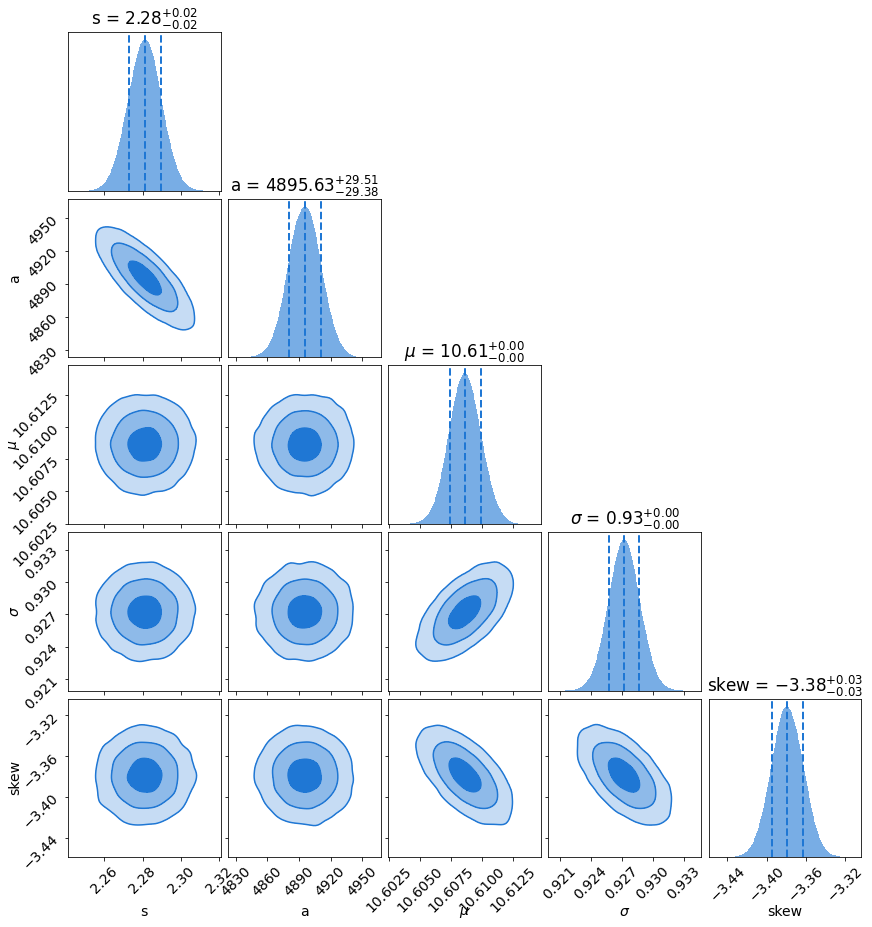

In [31]:
fig, axes = dyplot.cornerplot(dres1_V2_Mstar, smooth=0.03, 
                              labels=labels1_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(5, 5, figsize=(2.5*5, 2.6*5)), 
                              color='#1f77d4')

In [32]:
lnzM1_V2_Mstar = dres1_V2_Mstar.logz[-1]
lnzM1_V2_Mstar

-9551.566918525365

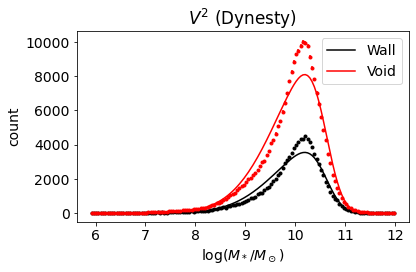

In [37]:
Model_1_plot([2.28, 4895.63, 10.61, 0.93, -3.38], 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             1, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$ (Dynesty)')

In [38]:
def prior_xform1_uni_VF(u):
    '''
    Priors for the 5 parameters of unimodel M1.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    s = uniform(0.1, 1, u[0])
    a = jeffreys(8000, 50000, u[1])
    mu = uniform(10, 11, u[2])
    sigma = uniform(0.1, 1.5, u[3])
    skew = uniform(-5, 0, u[4])

    return s, a, mu, sigma, skew

In [39]:
Model_1_sampler(prior_xform1_uni_VF, 
                Mstar_NSA[wall_vf], 
                Mstar_NSA[void_vf], 
                Mstar_bins, 
                1, 
                '_Mstar_VoidFinder')

running the nested sampler... this might take from minutes to hours...


31812it [03:57, 133.72it/s, batch: 9 | bound: 101 | nc: 1 | ncall: 90511 | eff(%): 35.147 | loglstar: -10225.307 < -10217.982 < -10219.114 | logz: -10246.356 +/-  0.316 | stop:  0.949]    

sampler output saved as pickle file 'dynesty_output/sampler_results_model1_Mstar_VoidFinder'


In [40]:
temp_infile = open('dynesty_output/sampler_results_model1_Mstar_VoidFinder.pickle', 'rb')
dres1_VF_Mstar = pickle.load(temp_infile)
temp_infile.close()

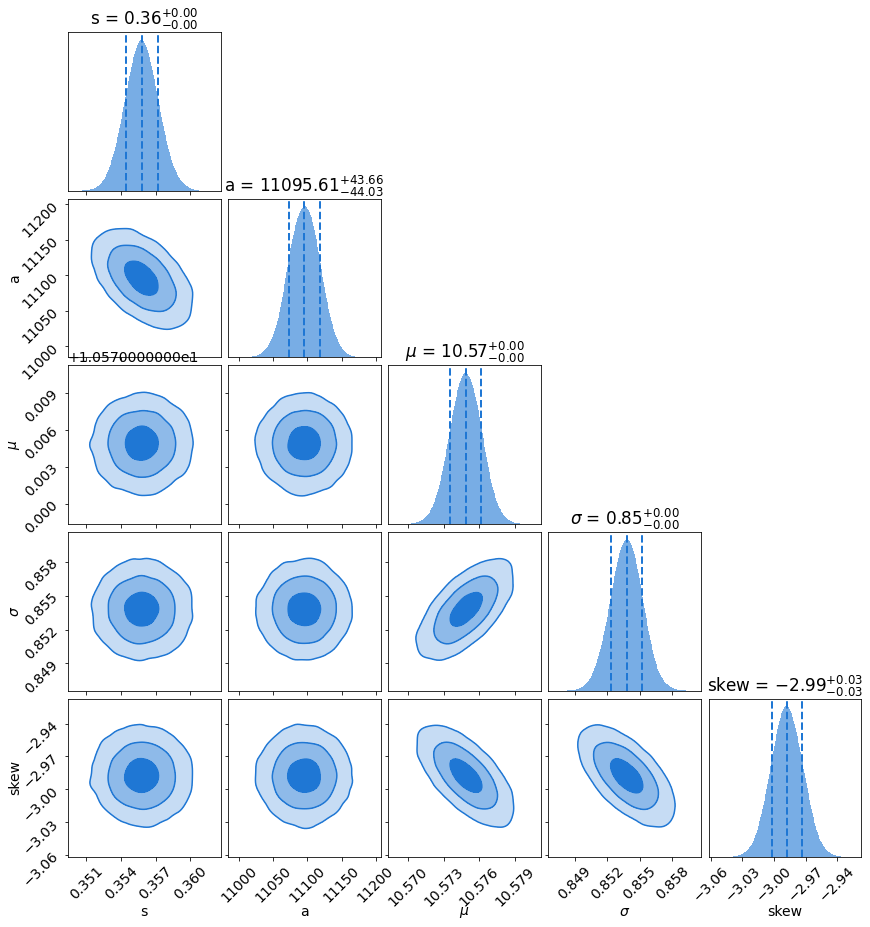

In [41]:
fig, axes = dyplot.cornerplot(dres1_VF_Mstar, smooth=0.03, 
                              labels=labels1_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(5, 5, figsize=(2.5*5, 2.6*5)), 
                              color='#1f77d4')

In [42]:
lnzM1_VF_Mstar = dres1_VF_Mstar.logz[-1]
lnzM1_VF_Mstar

-10246.368611719676

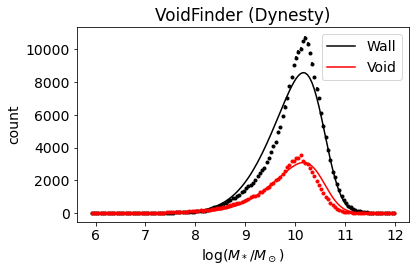

In [43]:
Model_1_plot([0.36, 11095.61, 10.57, 0.85, -2.99], 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             1, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='VoidFinder (Dynesty)')

### 2-parent model

In [44]:
Mstar_fit_bounds2 = [[2000, 50000], # a ........ Gaussian A amplitude
                     [10, 11],      # mu_a ..... Gaussian A location
                     [0.1, 1],      # sigma_a .. Gaussian A scale
                     [-4, -1],      # skew_a ... Gaussian A skew
                     [3000, 50000], # b ........ Gaussian B amplitude
                     [10, 11],      # mu_b ..... Gaussian B location
                     [0.1, 1],      # sigma_b .. Gaussian B scale
                     [-4, -1]]      # skew_b ... Gaussian B skew

V2_Mstar_bestfit2 = Model_2_fit(Mstar_fit_bounds2, 
                                Mstar_NSA[wall_v2], 
                                Mstar_NSA[void_v2], 
                                Mstar_bins, 
                                1, 
                                p0=[4640, 10.54, 0.73, -2.91, 10624, 10.54, 0.74, -2.95])

VF_Mstar_bestfit2 = Model_2_fit(Mstar_fit_bounds2, 
                                Mstar_NSA[wall_vf], 
                                Mstar_NSA[void_vf], 
                                Mstar_bins, 
                                1, 
                                p0=[10645, 10.53, 0.68, -2.53, 3808, 10.46, 0.81, -3.41])

running minimizer...this might take a few minutes...
running minimizer...this might take a few minutes...


In [45]:
V2_Mstar_bestfit2

      fun: 9961.870363390532
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-1.21018645,  0.41272866,  0.51604729,  0.75906428, -1.12713714,
       -3.69836895, -0.961154  ,  0.49367373])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 198
      nit: 20
     njev: 22
   status: 0
  success: True
        x: array([ 4.63974615e+03,  1.06163191e+01,  9.28421678e-01, -3.39701833e+00,
        1.06237634e+04,  1.06051746e+01,  9.26595406e-01, -3.37010451e+00])

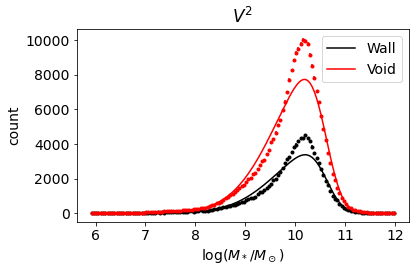

In [46]:
Model_2_plot(V2_Mstar_bestfit2.x, 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             1, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$')

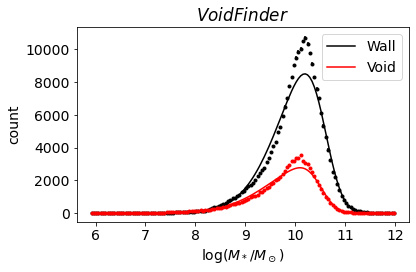

In [47]:
Model_2_plot(VF_Mstar_bestfit2.x, 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             1, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$VoidFinder$')

In [48]:
VF_Mstar_bestfit2

      fun: 6211.25243147455
 hess_inv: <8x8 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.92851946,  0.28148859, -0.33833203,  0.18699211, -0.80591178,
        0.08622009, -0.02637535,  0.44874469])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 225
      nit: 22
     njev: 25
   status: 0
  success: True
        x: array([ 1.06449025e+04,  1.05869296e+01,  8.06329240e-01, -2.74339544e+00,
        3.80791574e+03,  1.05069540e+01,  9.42811767e-01, -3.66222079e+00])

#### Nested sampling of Likelihood and Priors

In [49]:
def prior_xform2_uni_V2(u):
    '''
    Priors for the 8 parameters of unimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a = jeffreys(2000, 6000, u[0])
    mu_a = uniform(10, 11, u[1])
    sigma_a = uniform(0.1, 2, u[2])
    skew_a = uniform(-4, -1, u[3])

    b = jeffreys(5000, 50000, u[4])
    mu_b = uniform(10, 11, u[5])
    sigma_b = uniform(0.1, 2, u[6])
    skew_b = uniform(-4, -1, u[7])

    return a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [50]:
Model_2_sampler(prior_xform2_uni_V2, 
                Mstar_NSA[wall_v2], 
                Mstar_NSA[void_v2], 
                Mstar_bins, 
                1, 
                '_Mstar_V2')

running the nested sampler... this might take from minutes to hours...


34130it [04:29, 126.59it/s, batch: 7 | bound: 132 | nc: 3 | ncall: 114200 | eff(%): 29.886 | loglstar: -9517.253 < -9509.554 < -9516.797 | logz: -9551.114 +/-  0.385 | stop:  0.986]       

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_Mstar_V2'


In [51]:
temp_infile = open('dynesty_output/sampler_results_model2_Mstar_V2.pickle', 'rb')
dres2_V2_Mstar = pickle.load(temp_infile)
temp_infile.close()

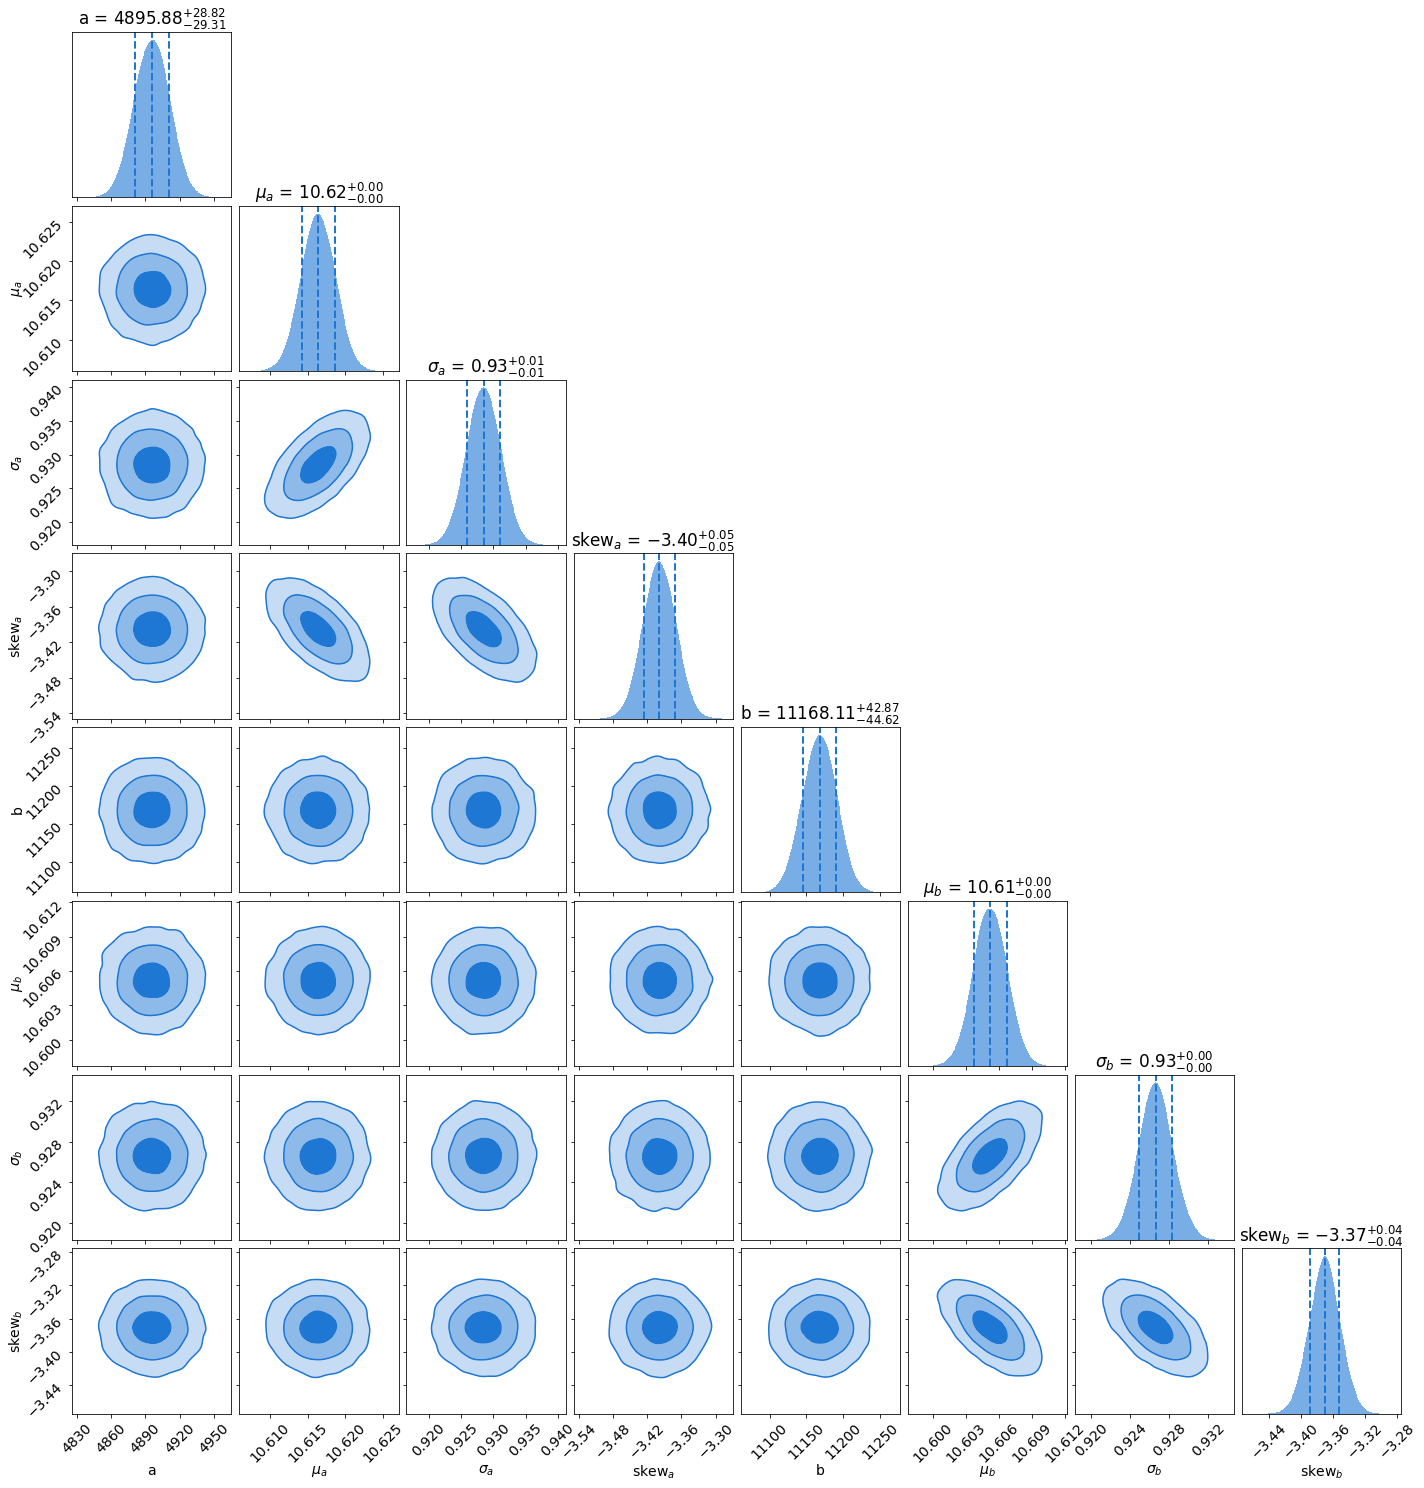

In [52]:
fig, axes = dyplot.cornerplot(dres2_V2_Mstar, smooth=0.03, 
                              labels=labels2_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(8, 8, figsize=(2.5*8, 2.6*8)), 
                              color='#1f77d4')

In [53]:
lnzM2_V2_Mstar = dres2_V2_Mstar.logz[-1]
lnzM2_V2_Mstar

-9551.131474304939

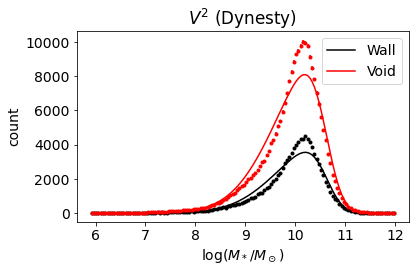

In [54]:
Model_2_plot([4895.88, 10.62, 0.93, -3.40, 11168.11, 10.61, 0.93, -3.37], 
             Mstar_NSA[wall_v2], 
             Mstar_NSA[void_v2], 
             Mstar_bins, 
             1, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='$V^2$ (Dynesty)')

In [55]:
def prior_xform2_uni_VF(u):
    '''
    Priors for the 8 parameters of unimodel M2.  Required by the dynesty 
    sampler.


    PARAMETERS
    ==========

    u : ndarray
        Array of uniform random numbers between 0 and 1.


    RETURNS
    =======
    
    priors : ndarray
        Transformed random numbers giving prior ranges on model parameters.
    '''

    a = jeffreys(9000, 50000, u[0])
    mu_a = uniform(10, 11, u[1])
    sigma_a = uniform(0.1, 1, u[2])
    skew_a = uniform(-3, -2, u[3])

    b = jeffreys(3500, 4500, u[4])
    mu_b = uniform(10, 11, u[5])
    sigma_b = uniform(0.5, 1.5, u[6])
    skew_b = uniform(-4, -3, u[7])

    return a, mu_a, sigma_a, skew_a, b, mu_b, sigma_b, skew_b

In [56]:
Model_2_sampler(prior_xform2_uni_VF, 
                Mstar_NSA[wall_vf], 
                Mstar_NSA[void_vf], 
                Mstar_bins, 
                1, 
                '_Mstar_VoidFinder')

running the nested sampler... this might take from minutes to hours...


36347it [04:20, 139.32it/s, batch: 7 | bound: 130 | nc: 1 | ncall: 114928 | eff(%): 31.626 | loglstar: -5957.970 < -5949.170 < -5950.512 | logz: -5985.844 +/-  0.354 | stop:  0.920]      

sampler output saved as pickle file 'dynesty_output/sampler_results_model2_Mstar_VoidFinder'


In [57]:
temp_infile = open('dynesty_output/sampler_results_model2_Mstar_VoidFinder.pickle', 'rb')
dres2_VF_Mstar = pickle.load(temp_infile)
temp_infile.close()

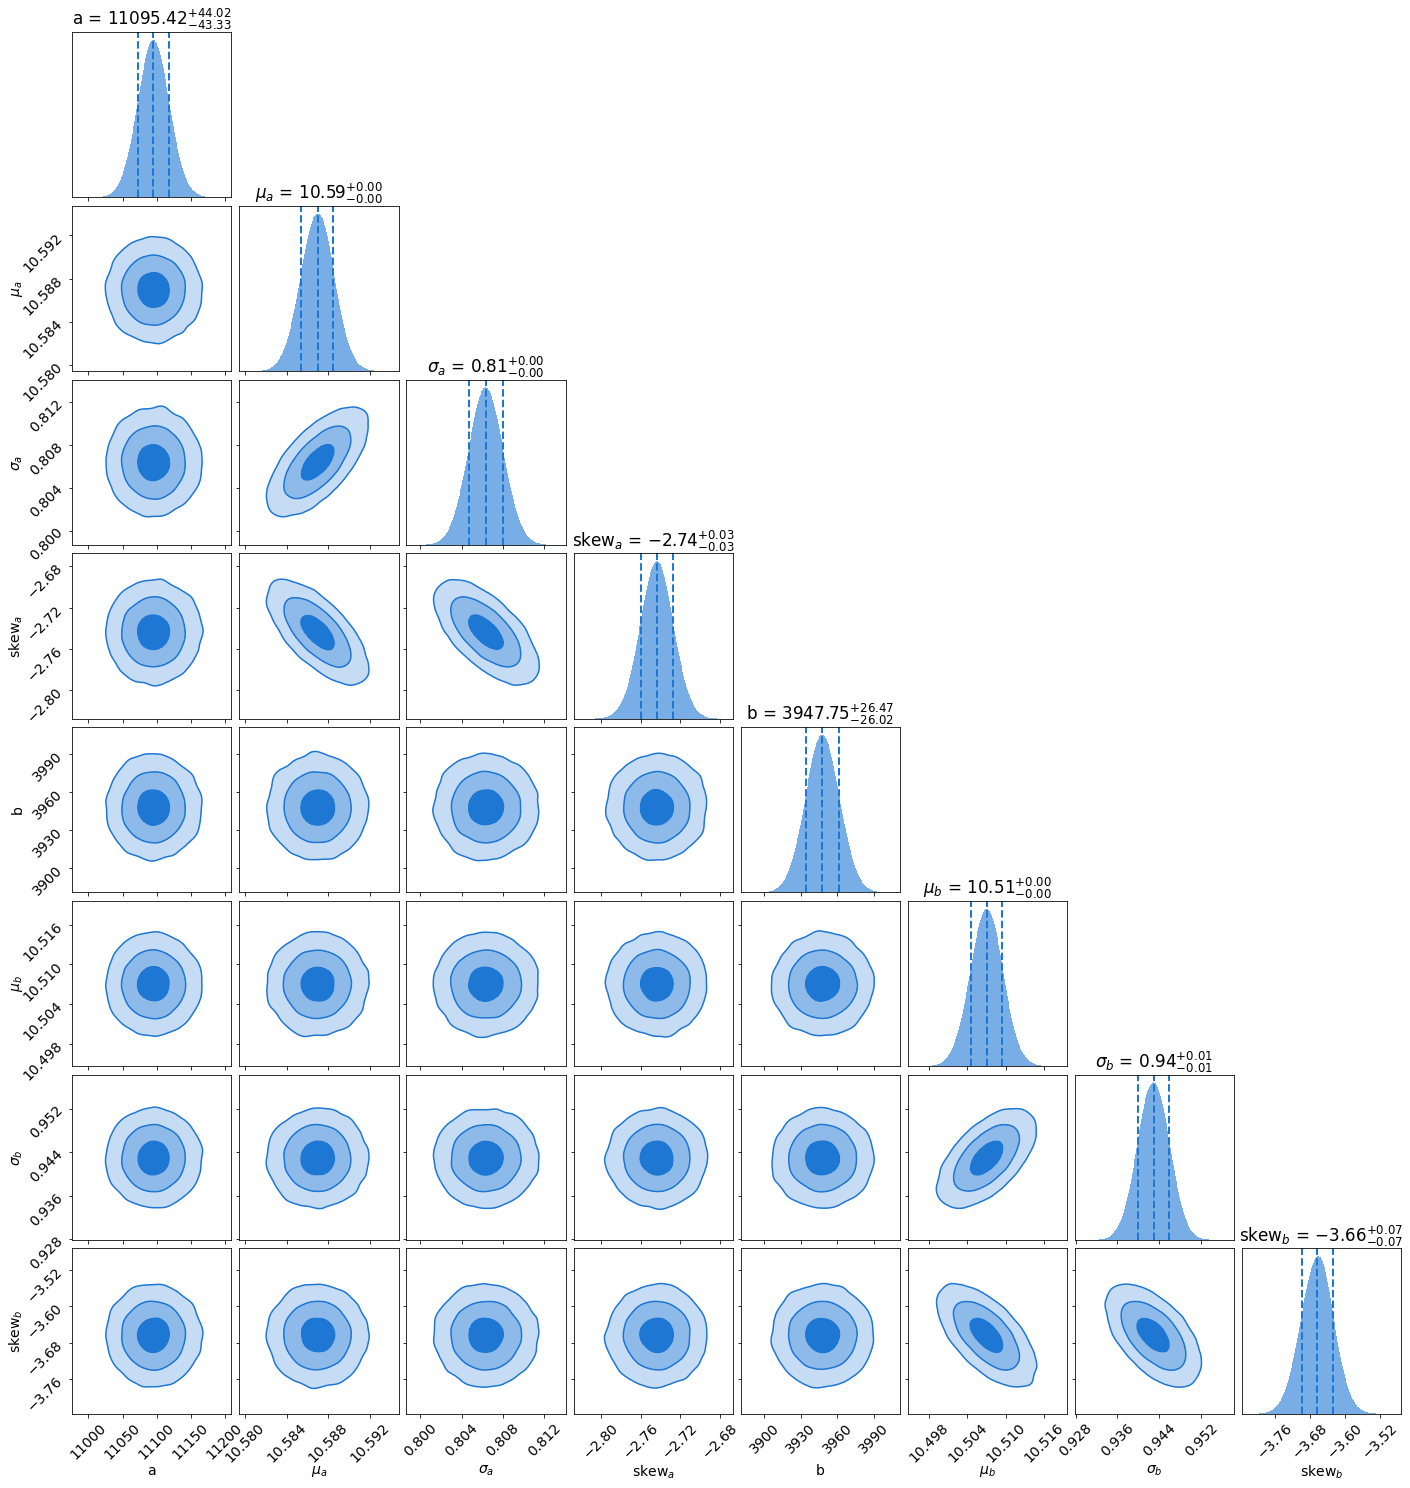

In [58]:
fig, axes = dyplot.cornerplot(dres2_VF_Mstar, smooth=0.03, 
                              labels=labels2_uni, 
                              show_titles=True, 
                              quantiles_2d=[1-np.exp(-0.5*r**2) for r in [1, 2, 3]], 
                              quantiles=[0.16, 0.5, 0.84], 
                              fig=plt.subplots(8, 8, figsize=(2.5*8, 2.6*8)), 
                              color='#1f77d4')

In [59]:
lnzM2_VF_Mstar = dres2_VF_Mstar.logz[-1]
lnzM2_VF_Mstar

-5985.852467161349

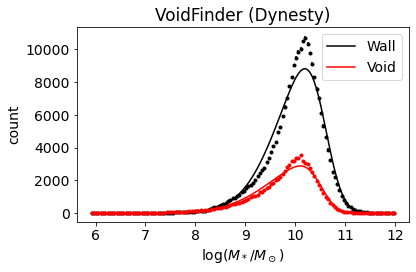

In [60]:
Model_2_plot([11095.42, 10.59, 0.81, -2.74, 3947.75, 10.51, 0.94, -3.66], 
             Mstar_NSA[wall_vf], 
             Mstar_NSA[void_vf], 
             Mstar_bins, 
             1, 
             xlabel_text='log($M_*/M_\odot$)', 
             title_text='VoidFinder (Dynesty)')

## Bayes Factor

In [61]:
lnB12_V2_Mstar = lnzM1_V2_Mstar - lnzM2_V2_Mstar

B12_V2_Mstar = np.exp(lnB12_V2_Mstar)

print('V2 Mstar: B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_V2_Mstar, np.log10(B12_V2_Mstar)))

V2 Mstar: B12 = 0.647; log(B12) = -0.189


In [62]:
lnB12_VF_Mstar = lnzM1_VF_Mstar - lnzM2_VF_Mstar

B12_VF_Mstar = np.exp(lnB12_VF_Mstar)

#print('VoidFinder Mstar: B12 = {:.3g}; log(B12) = {:.3g}'.format(B12_VF_Mstar, np.log10(B12_VF_Mstar)))
print('VoidFinder Mstar: B12 = {:.3g}; log(B12) = {:.3f}'.format(B12_VF_Mstar, lnB12_VF_Mstar*np.log10(np.exp(1))))

VoidFinder Mstar: B12 = 0; log(B12) = -1850.319


So model $\mathcal{M}_2$, in which the two data sets come from different parent distributions, is slightly favored (by less than one order of magnitude) for the $V^2$ $M_*$ distribution.

And model $\mathcal{M}_2$, in which the two data sets come from different parent distributions, is overwhelmingly favored by 1850 orders of magnitude for the VoidFinder $M_*$ distribution.